In [ ]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from v1dd_public import ARTIFACT_DIR
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

In [15]:
## Load in cell_info dataframe to look at population trends
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

In [16]:
# -----------------------------
# Helper to convert p → stars
# -----------------------------
def p_to_stars(p):
    alpha_levels = [0.05, 0.01, 0.001, 0.0001]  # thresholds for *, **, ***, ****
    if np.isnan(p):
        return ""
    if p < alpha_levels[3]:
        return "****"
    elif p < alpha_levels[2]:
        return "***"
    elif p < alpha_levels[1]:
        return "**"
    elif p < alpha_levels[0]:
        return "*"
    return ""

## SUPPLEMENTARY FIGURE 6A -- DGW METRIC DEPTH TREND STATISTICS

/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Depth effect (likelihood ratio test): χ²(39) = 2131.12, p = 0
Best depth = 274, mean accuracy = 0.596


/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Depth effect (likelihood ratio test): χ²(39) = 1698.93, p = 0
Best depth = 274, mean accuracy = 0.541


/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Depth effect (likelihood ratio test): χ²(39) = 3736.27, p = 0
Best depth = 274, mean accuracy = 0.756


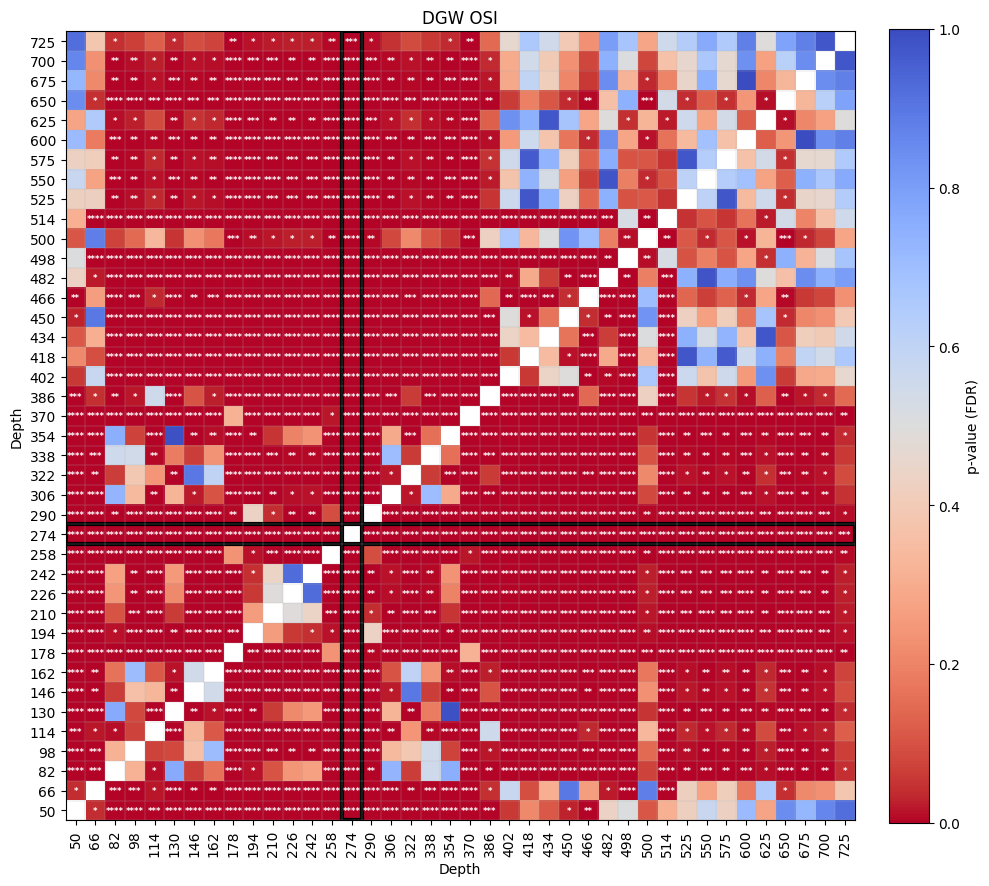

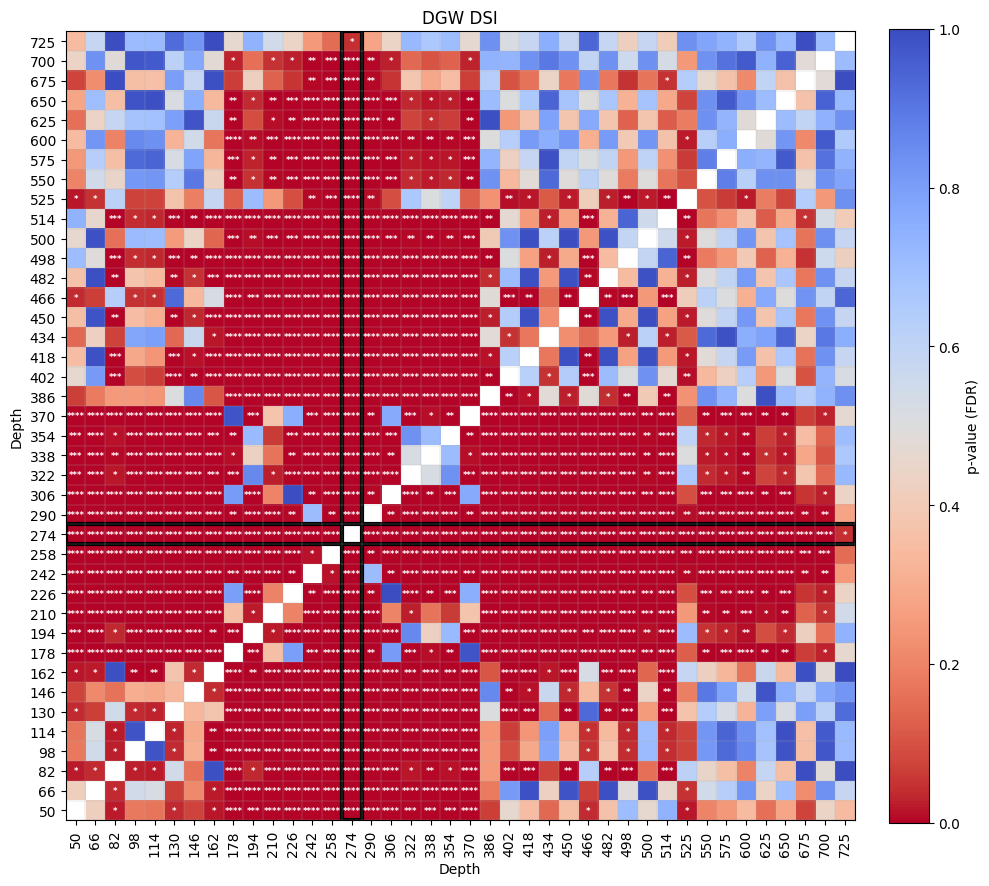

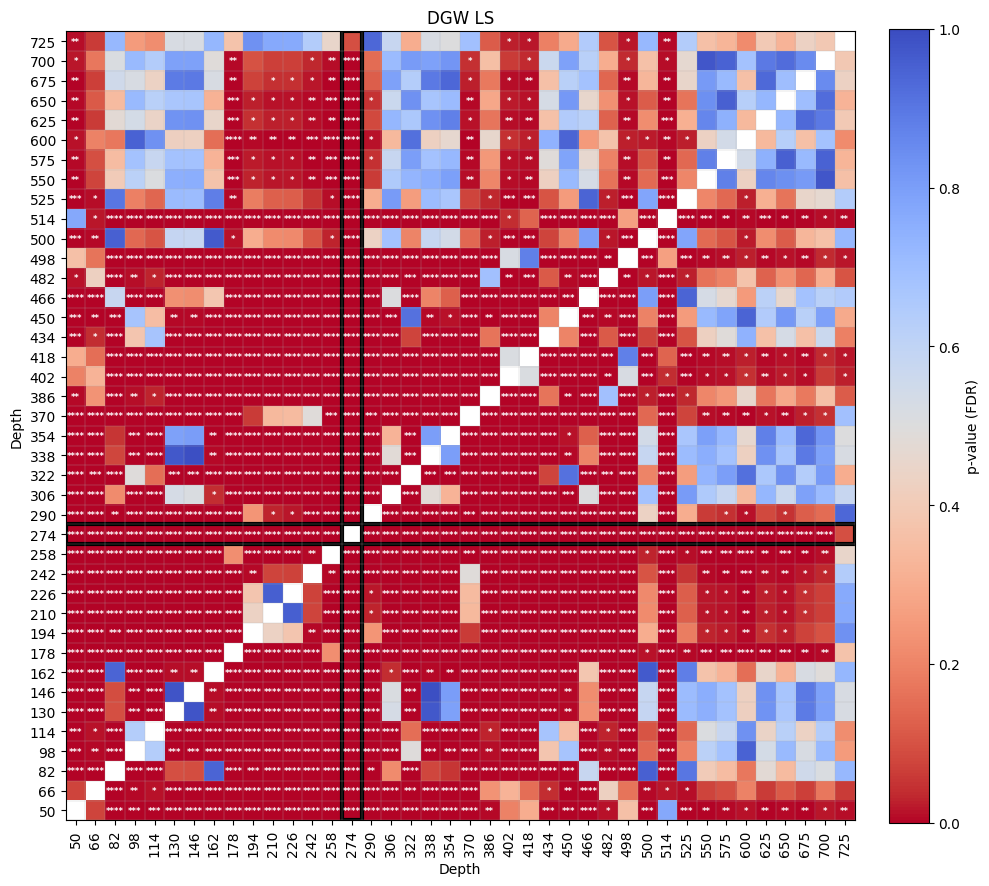

In [25]:
stim_list = ['dgw_osi', 'dgw_dsi', 'dgw_ls']
titles = ['DGW OSI', 'DGW DSI', 'DGW LS']

for idx, stim_type in enumerate(stim_list):
    df = cell_info[['mouse_id', 'column', 'z', stim_type]]
    df = df.sort_values(by='z').reset_index(drop=True)
    df['mouse_id'] = df['mouse_id'].astype('category')
    df['column'] = df['column'].astype('category')
    df['z'] = df['z'].astype('category')
    depth_levels = df.z.unique()

    # 2) Fit the mixed model: metric ~ depth + (1|mouse) + (1|mouse:column)
    res = smf.mixedlm(
        f"{stim_type} ~ C(z)",
        data=df,
        groups=df["mouse_id"],
        re_formula="~1",
        vc_formula={"column": "0 + C(column)"}
    ).fit(method="lbfgs")

    # Reduced model: no depth term (intercept only)
    res_reduced = smf.mixedlm(
        f"{stim_type} ~ 1",
        data=df,
        groups=df["mouse_id"],
        re_formula="~1",
        vc_formula={"column": "0 + C(column)"}
    ).fit(method="lbfgs")

    # Likelihood ratio test
    lr_stat = 2 * (res.llf - res_reduced.llf)
    df_diff = res.df_modelwc - res_reduced.df_modelwc
    p_value = stats.chi2.sf(lr_stat, df_diff)

    print(f"Depth effect (likelihood ratio test): χ²({int(df_diff)}) = {lr_stat:.2f}, p = {p_value:.4g}")

    # 3) Build “EMM” vectors (fixed-effects means per depth)
    fe_names = res.fe_params.index.tolist()
    beta = res.fe_params.values
    Sigma = res.cov_params().loc[fe_names, fe_names].values  # cov of fixed effects
    baseline = depth_levels[0]

    def v_for(level):
        v = np.zeros(len(fe_names))
        v[fe_names.index("Intercept")] = 1.0
        name = f"C(z)[T.{level}]"
        if name in fe_names: v[fe_names.index(name)] = 1.0
        return v

    R = np.vstack([v_for(d) for d in depth_levels])  # rows are depths

    # 4) Pairwise contrasts for all depth pairs
    rows = []
    for i, j in itertools.combinations(range(len(depth_levels)), 2):
        L = R[i] - R[j]
        diff = float(L @ beta)
        se   = float(np.sqrt(L @ Sigma @ L))
        z    = diff / se if se > 0 else np.inf
        p    = 2 * (1 - norm.cdf(abs(z)))
        rows.append({
            "depth_a": depth_levels[i],
            "depth_b": depth_levels[j],
            "diff": diff,
            "se": se,
            "z": z,
            "p_raw": p
        })
    contrasts = pd.DataFrame(rows)

    # 5) Add FDR (BH)
    contrasts["p_fdr_bh"]    = multipletests(contrasts["p_raw"], method="fdr_bh")[1]

    # Done: 'contrasts' now has raw and FDR p-values for every pair
    contrasts.sort_values("p_fdr_bh", inplace=True)

    ########### Plotting ###########
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    show_upper_triangle_only = False             # set False to show entire matrix
    mark_diagonal = False                       # usually we leave diagonal unmarked

    ## Build the matrix of p-values
    depth_to_idx = {d:i for i,d in enumerate(depth_levels)}
    K = len(depth_levels)

    P = np.ones((K, K), dtype=float)  # initialize to 1s (diagonal = 1)
    for _, row in contrasts.iterrows():
        i = depth_to_idx[row["depth_a"]]
        j = depth_to_idx[row["depth_b"]]
        p = float(row["p_fdr_bh"])
        P[i, j] = p
        P[j, i] = p

    if not mark_diagonal:
        np.fill_diagonal(P, np.nan)  # keep diagonal neutral/blank

    # Optionally only plot upper triangle
    if show_upper_triangle_only:
        mask = np.tril(np.ones_like(P, dtype=bool), k=0)  # lower triangle + diag masked
        P_plot = P.copy()
        P_plot[mask] = np.nan
    else:
        P_plot = P

    im = ax.imshow(P_plot, origin="lower", interpolation="nearest", vmin=0, vmax=1, cmap="coolwarm_r", rasterized=True)

    # Colorbar labeled with plain p-values
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("p-value (FDR)")

    # Ticks & labels
    ax.set_xticks(np.arange(K))
    ax.set_yticks(np.arange(K))
    ax.set_xticklabels(depth_levels, rotation=90)
    ax.set_yticklabels(depth_levels)
    ax.set_xlabel("Depth")
    ax.set_ylabel("Depth")
    ax.set_title(f"{titles[idx]}") # - Pairwise Depth Comparisons (Mixed LME)\nHeat map of p-values with significance stars", fontsize=14)
    # ax.set_title("Pairwise depth comparisons (Mixed LME)\nHeat map of p-values with significance stars")

    # Overlay significance stars
    # Only annotate plotted (non-masked) cells
    for i in range(K):
        for j in range(K):
            p = P_plot[i, j]
            if np.isnan(p):
                continue
            stars = p_to_stars(p)
            if stars:
                ax.text(j, i, stars, ha="center", va="center", fontsize=6, fontweight="bold", color="white")

    # Add box around the depth with the highest average accuracy
    depth_means = df.groupby("z")[stim_type].mean()
    best_depth = depth_means.idxmax()
    best_idx = list(depth_levels).index(best_depth)

    print(f"Best depth = {best_depth}, mean accuracy = {depth_means[best_depth]:.3f}")

    ax.add_patch(plt.Rectangle((-0.5, best_idx-0.5),
                            len(depth_levels), 1,
                            fill=False, edgecolor="black", linewidth=3))
    # Rectangle for the column
    ax.add_patch(plt.Rectangle((best_idx-0.5, -0.5),
                            1, len(depth_levels),
                            fill=False, edgecolor="black", linewidth=3))


    # Optional thin grid for readability
    ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.2)
    ax.tick_params(which="minor", length=0)

    plt.tight_layout()
    plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f"SUPPFIG5A_{stim_type}_stats.png"), format="png", dpi=300)

## SUPPLEMENTARY FIGURE 5B (DGF METRICS DEPTH TRENDS)

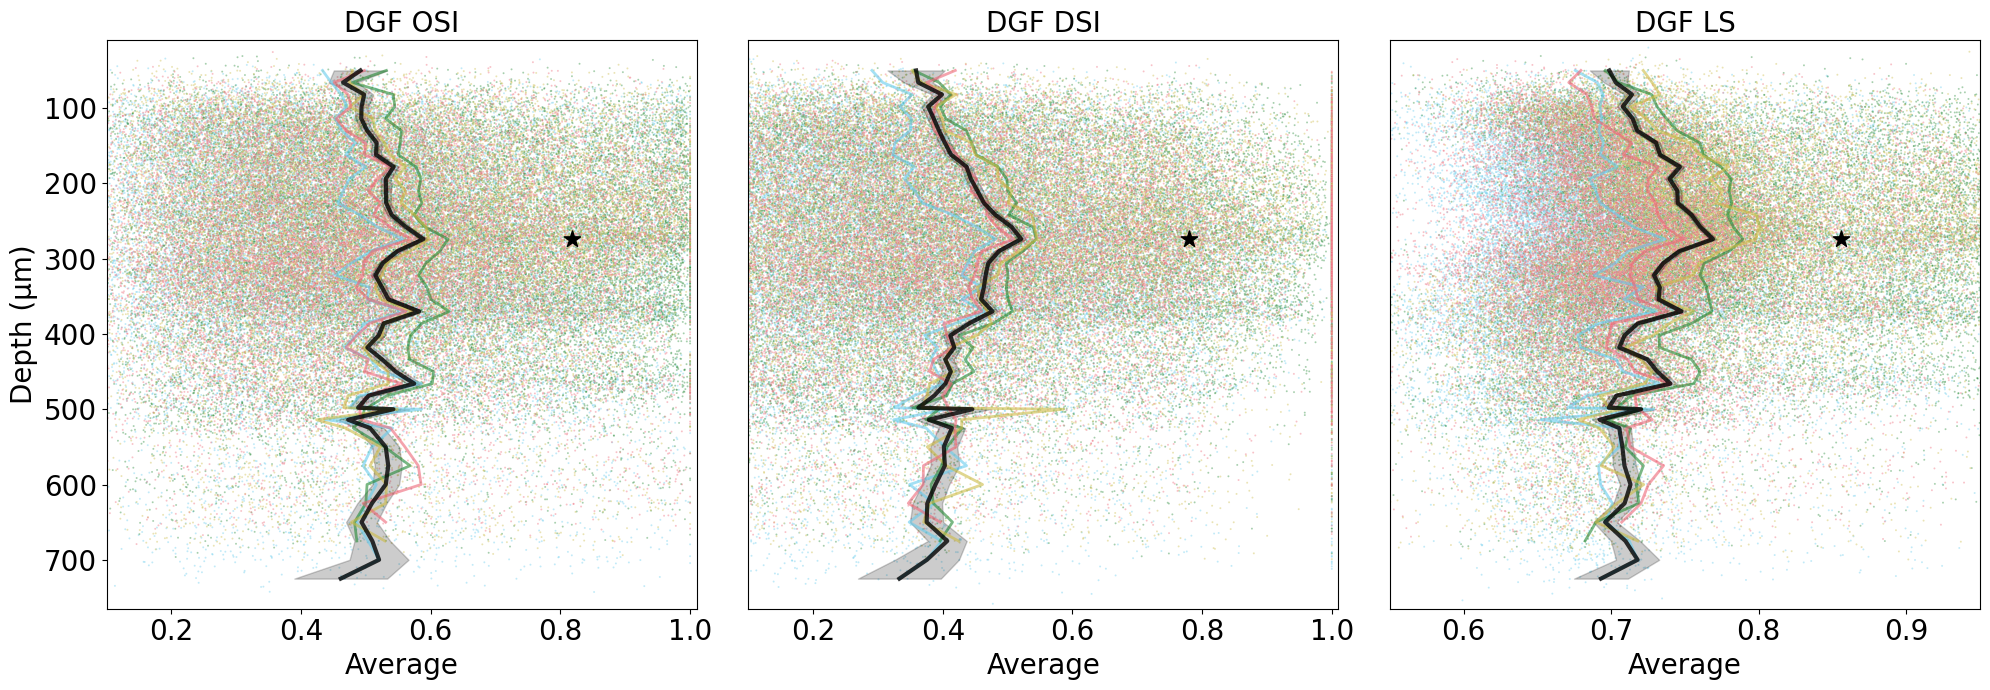

In [26]:
## Plot depth trends for DGF metrics
fontsize = 20
jitter_amount = 10
z_values = cell_info['z'].values

stim_list = ['dgf_osi', 'dgf_dsi', 'dgf_ls']
titles = ['DGF OSI', 'DGF DSI', 'DGF LS']
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}

fig, axs = plt.subplots(1, len(stim_list), figsize=(20, 7))
for idx, stim in enumerate(stim_list):
    sns.lineplot(data=cell_info, 
                 x=stim, 
                 y='z',  
                 hue='mouse_id', 
                 estimator='mean',
                 palette=mouse_colors, 
                 linewidth=2, 
                 errorbar=None, 
                 alpha=0.6, 
                 orient='y', 
                 markers=True,
                 ax=axs[idx],
                 legend=False
                 )

    sns.lineplot(data=cell_info, 
                 x=stim, 
                 y='z', 
                 color='black', 
                 estimator='mean',
                 err_style='band', 
                 errorbar=('se', 2), 
                 n_boot=1000, 
                 linewidth=3, 
                 alpha=0.8, 
                 orient='y', 
                 ax=axs[idx], 
                 legend=False)

    temp_df = cell_info.copy()
    temp_df['z'] = temp_df['z'] + np.random.normal(0, jitter_amount, size=len(temp_df))

    if stim == 'dgf_pref_dir' or stim == 'dgw_pref_dir':
        temp_df[stim] = temp_df[stim] + np.random.normal(0, jitter_amount, size=len(temp_df))

    sns.scatterplot(data=temp_df,
                    x=stim,
                    y='z',
                    hue='mouse_id',
                    palette=mouse_colors,
                    s=2,
                    alpha=0.4,
                    ax=axs[idx],
                    legend=False,
                    zorder=0,
    )

    # Put asterisk next to the depth where the max median
    sub_df = cell_info.groupby('z')[stim].mean().reset_index()
    sub_array = sub_df[stim].values
    axs[idx].scatter(sub_array.max() + cell_info[stim].std(), sub_df.iloc[np.where(sub_array == sub_array.max())].z.values[0], 
            color='black', marker='*', s=150, edgecolor='black', zorder=1)

    axs[idx].set_xlabel('Average', fontsize=fontsize)
    axs[idx].set_title(titles[idx], fontsize=fontsize)
    axs[idx].set_ylabel("Depth (µm)", fontsize=fontsize) if idx == 0 else axs[idx].set_ylabel(" ")
    axs[idx].set_yticks([]) if idx != 0 else None
    axs[idx].set_ylim(z_values.min() - 40, z_values.max() + 40)
    axs[idx].set_xlim(0.1, 1.01) if idx < 2 else axs[idx].set_xlim(0.55, 0.95)
    axs[idx].tick_params(axis="both", which="major", labelsize=fontsize)
    axs[idx].invert_yaxis()

plt.tight_layout()
fig.savefig(os.path.join(ARTIFACT_DIR, "figures", "SUPPFIG5B_DGF_depth_plots.png"), format='png', dpi=300)

## SUPPLEMENTARY FIGURE 6C -- DGF METRIC DEPTH TREND STATISTICS

/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Depth effect (likelihood ratio test): χ²(39) = 988.61, p = 5.471e-182
Best depth = 274, mean accuracy = 0.589


/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Depth effect (likelihood ratio test): χ²(39) = 1942.40, p = 0
Best depth = 274, mean accuracy = 0.521


/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Depth effect (likelihood ratio test): χ²(39) = 3825.61, p = 0
Best depth = 274, mean accuracy = 0.769


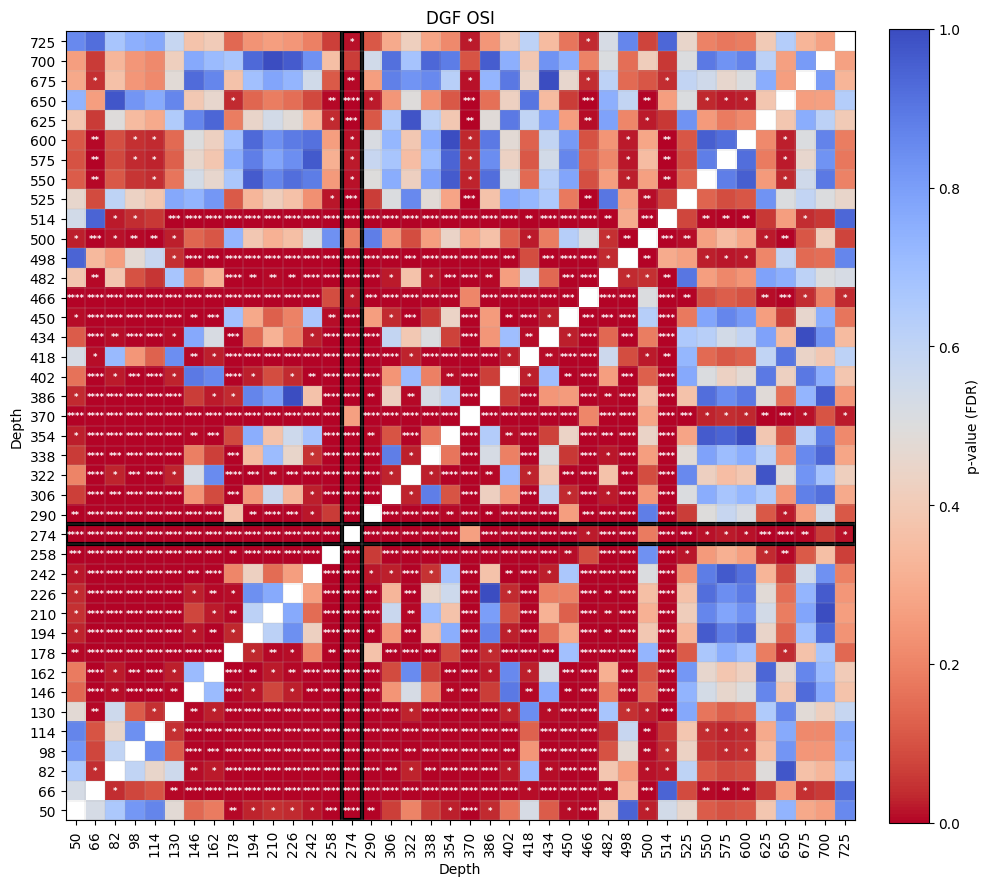

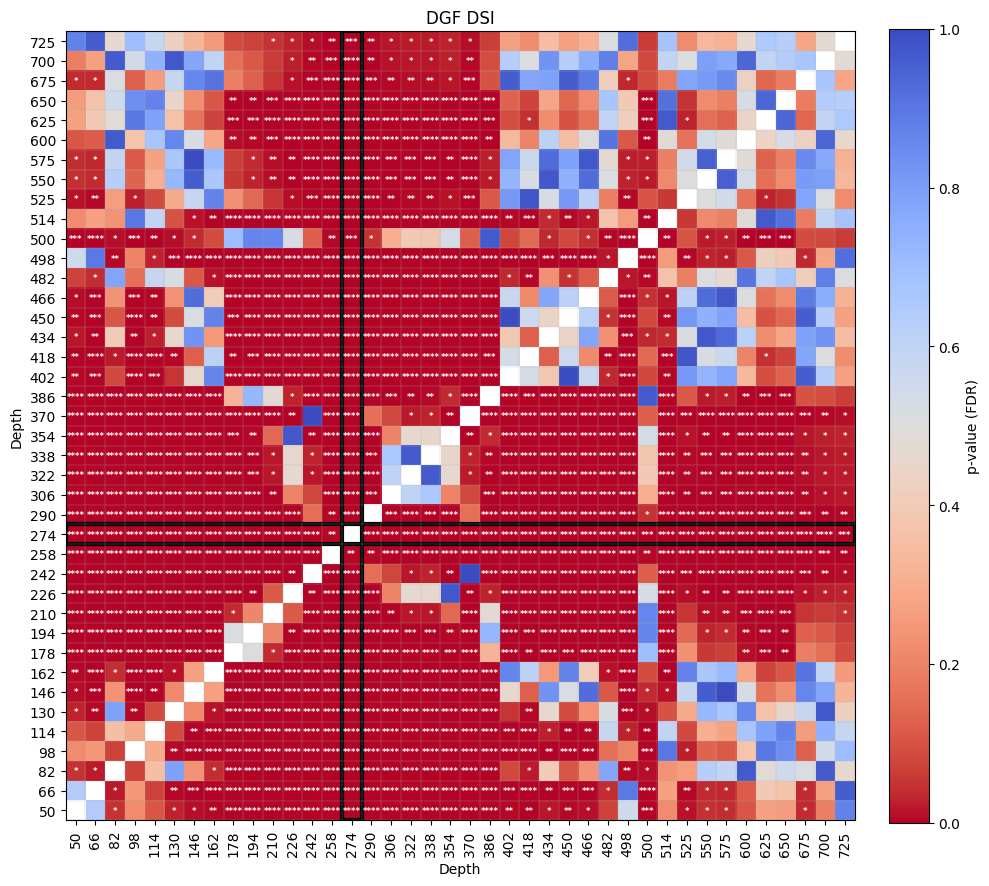

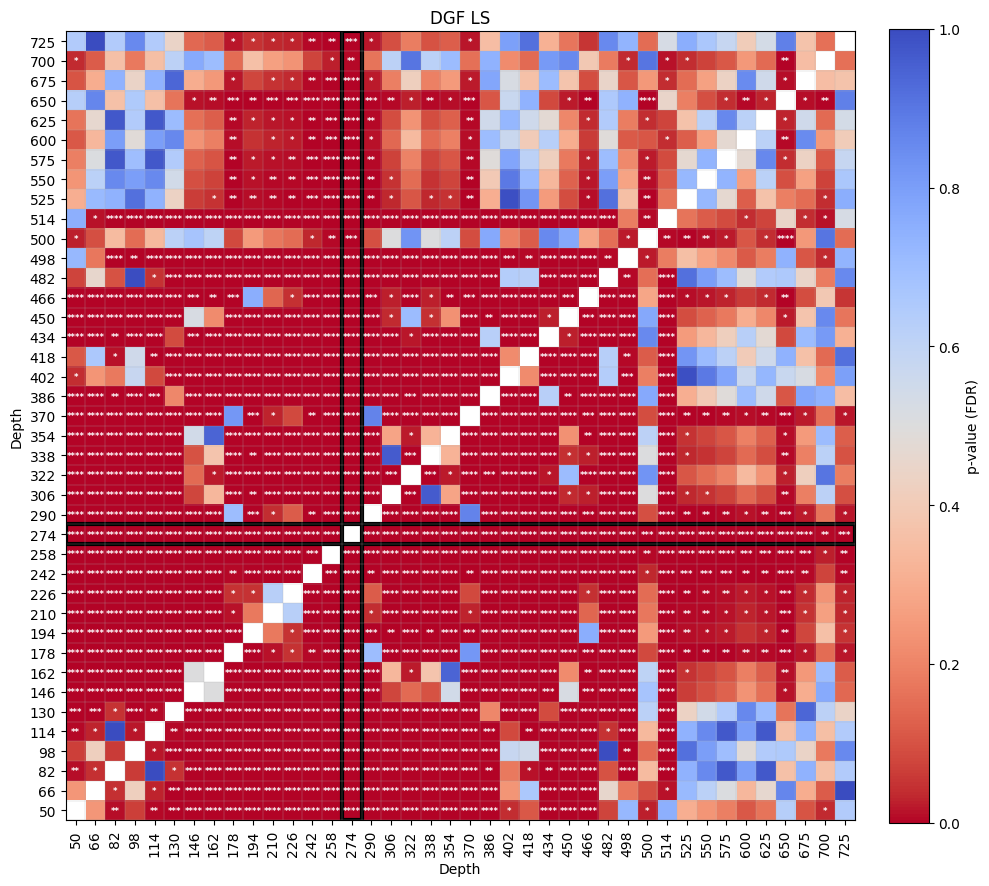

In [27]:
stim_list = ['dgf_osi', 'dgf_dsi', 'dgf_ls']
titles = ['DGF OSI', 'DGF DSI', 'DGF LS']

for idx, stim_type in enumerate(stim_list):
    df = cell_info[['mouse_id', 'column', 'z', stim_type]]
    df = df.sort_values(by='z').reset_index(drop=True)
    df['mouse_id'] = df['mouse_id'].astype('category')
    df['column'] = df['column'].astype('category')
    df['z'] = df['z'].astype('category')
    depth_levels = df.z.unique()

    # 2) Fit the mixed model: metric ~ depth + (1|mouse) + (1|mouse:column)
    res = smf.mixedlm(
        f"{stim_type} ~ C(z)",
        data=df,
        groups=df["mouse_id"],
        re_formula="~1",
        vc_formula={"column": "0 + C(column)"}
    ).fit(method="lbfgs")

    # Reduced model: no depth term (intercept only)
    res_reduced = smf.mixedlm(
        f"{stim_type} ~ 1",
        data=df,
        groups=df["mouse_id"],
        re_formula="~1",
        vc_formula={"column": "0 + C(column)"}
    ).fit(method="lbfgs")

    # Likelihood ratio test
    lr_stat = 2 * (res.llf - res_reduced.llf)
    df_diff = res.df_modelwc - res_reduced.df_modelwc
    p_value = stats.chi2.sf(lr_stat, df_diff)

    print(f"Depth effect (likelihood ratio test): χ²({int(df_diff)}) = {lr_stat:.2f}, p = {p_value:.4g}")

    # 3) Build “EMM” vectors (fixed-effects means per depth)
    fe_names = res.fe_params.index.tolist()
    beta = res.fe_params.values
    Sigma = res.cov_params().loc[fe_names, fe_names].values  # cov of fixed effects
    baseline = depth_levels[0]

    def v_for(level):
        v = np.zeros(len(fe_names))
        v[fe_names.index("Intercept")] = 1.0
        name = f"C(z)[T.{level}]"
        if name in fe_names: v[fe_names.index(name)] = 1.0
        return v

    R = np.vstack([v_for(d) for d in depth_levels])  # rows are depths

    # 4) Pairwise contrasts for all depth pairs
    rows = []
    for i, j in itertools.combinations(range(len(depth_levels)), 2):
        L = R[i] - R[j]
        diff = float(L @ beta)
        se   = float(np.sqrt(L @ Sigma @ L))
        z    = diff / se if se > 0 else np.inf
        p    = 2 * (1 - norm.cdf(abs(z)))
        rows.append({
            "depth_a": depth_levels[i],
            "depth_b": depth_levels[j],
            "diff": diff,
            "se": se,
            "z": z,
            "p_raw": p
        })
    contrasts = pd.DataFrame(rows)

    # 5) Add FDR (BH)
    contrasts["p_fdr_bh"]    = multipletests(contrasts["p_raw"], method="fdr_bh")[1]

    # Done: 'contrasts' now has raw and FDR p-values for every pair
    contrasts.sort_values("p_fdr_bh", inplace=True)

    ########### Plotting ###########
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    show_upper_triangle_only = False             # set False to show entire matrix
    mark_diagonal = False                       # usually we leave diagonal unmarked

    ## Build the matrix of p-values
    depth_to_idx = {d:i for i,d in enumerate(depth_levels)}
    K = len(depth_levels)

    P = np.ones((K, K), dtype=float)  # initialize to 1s (diagonal = 1)
    for _, row in contrasts.iterrows():
        i = depth_to_idx[row["depth_a"]]
        j = depth_to_idx[row["depth_b"]]
        p = float(row["p_fdr_bh"])
        P[i, j] = p
        P[j, i] = p

    if not mark_diagonal:
        np.fill_diagonal(P, np.nan)  # keep diagonal neutral/blank

    # Optionally only plot upper triangle
    if show_upper_triangle_only:
        mask = np.tril(np.ones_like(P, dtype=bool), k=0)  # lower triangle + diag masked
        P_plot = P.copy()
        P_plot[mask] = np.nan
    else:
        P_plot = P

    im = ax.imshow(P_plot, origin="lower", interpolation="nearest", vmin=0, vmax=1, cmap="coolwarm_r", rasterized=True)

    # Colorbar labeled with plain p-values
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("p-value (FDR)")

    # Ticks & labels
    ax.set_xticks(np.arange(K))
    ax.set_yticks(np.arange(K))
    ax.set_xticklabels(depth_levels, rotation=90)
    ax.set_yticklabels(depth_levels)
    ax.set_xlabel("Depth")
    ax.set_ylabel("Depth")
    ax.set_title(f"{titles[idx]}") # - Pairwise Depth Comparisons (Mixed LME)\nHeat map of p-values with significance stars", fontsize=14)
    # ax.set_title("Pairwise depth comparisons (Mixed LME)\nHeat map of p-values with significance stars")

    # Overlay significance stars
    # Only annotate plotted (non-masked) cells
    for i in range(K):
        for j in range(K):
            p = P_plot[i, j]
            if np.isnan(p):
                continue
            stars = p_to_stars(p)
            if stars:
                ax.text(j, i, stars, ha="center", va="center", fontsize=6, fontweight="bold", color="white")

    # Add box around the depth with the highest average accuracy
    depth_means = df.groupby("z")[stim_type].mean()
    best_depth = depth_means.idxmax()
    best_idx = list(depth_levels).index(best_depth)

    print(f"Best depth = {best_depth}, mean accuracy = {depth_means[best_depth]:.3f}")

    ax.add_patch(plt.Rectangle((-0.5, best_idx-0.5),
                            len(depth_levels), 1,
                            fill=False, edgecolor="black", linewidth=3))
    # Rectangle for the column
    ax.add_patch(plt.Rectangle((best_idx-0.5, -0.5),
                            1, len(depth_levels),
                            fill=False, edgecolor="black", linewidth=3))


    # Optional thin grid for readability
    ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.2)
    ax.tick_params(which="minor", length=0)

    plt.tight_layout()
    plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f"SUPPFIG5C_{stim_type}_stats.png"), format="png", dpi=300)